In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# Ex 6 - Staged construction

_Dr Dorival Pedroso_

## 1 Input data

### 1.1 Constants

Collect some generic constants (e.g. unit weight of water)

In [2]:
pi           = np.pi           # [-]
gamma_water  = 9.8             # kN/m³
secs_per_day = 24 * 60 * 60.0  # [-]

### 1.2 Soil foundation

Collect data related to the soil foundation

In [3]:
H_soil      = 6.0      # m
OCR_soil    = 1.0      # normally consolidated
cu_soil     = 24.0     # kPa
cv_soil     = 1.8e-8   # m²/s
Cc_soil     = 0.8      # [-]
Ca_soil     = 0.032    # [-]
e0_soil     = 1.0      # [-]
gamma_soil  = 18.1     # kN/m³
egamma_soil = gamma_soil - gamma_water # effective unit weight
cr_soil     = 2.5 * cv_soil

print(f'coef of consolidation due to radial flow, cr = {cr_soil} m²/s')

coef of consolidation due to radial flow, cr = 4.5e-08 m²/s


Estimate mv and the permeability of soil by considering two effective stresses esigA and esigB 'near' the expected stresses

In [4]:
esigA   = 100.0  # kPa
esigB   = 200.0  # kPa
mv_soil = (Cc_soil / (1.0 + e0_soil)) * np.log10(esigB / esigA) / (esigB - esigA)
kv_soil = cv_soil * mv_soil * gamma_water
kr_soil = 2.5 * kv_soil

print(f'mv_soil = {mv_soil:.6f} kPa⁻¹')
print(f'kv_soil = {kv_soil:.4} m/s')
print(f'kr_soil = {kr_soil:.4} m/s')

mv_soil = 0.001204 kPa⁻¹
kv_soil = 2.124e-10 m/s
kr_soil = 5.31e-10 m/s


### 1.3 Embankment / fill

Collect data related to the fill used in the embankment

In [5]:
H_fill     = 6.0    # m
gamma_fill = 19.7   # kN/m³
c_fill     = 0.0    # kPa
phi_fill   = 30.0   # degrees

### 1.4 Pre-fabricated vertical drains (PVDs)

Collect data related to the pre-fabricated vertical drains

In [6]:
b_drain       = 100.0     # mm
tg_drain      = 4.0       # mm
spacing_drain = 1.0       # m  (equilateral triangular pattern)
Qc_drain      = 0.000109  # m³/s

dc_drain = (b_drain/1000.0 + tg_drain/1000.0) / 2
de_drain = 1.06 * spacing_drain
Nd_drain = de_drain / dc_drain

print(f'equivalent diameter:            dc = {dc_drain:.4f} m')
print(f'equivalent influence diameter:  de = {de_drain} m')
print(f'diameter ratio:                 Nd = {Nd_drain:.2f}')

equivalent diameter:            dc = 0.0520 m
equivalent influence diameter:  de = 1.06 m
diameter ratio:                 Nd = 20.38


### 1.5 Geotechnical problem

Collect data related to the geotechnical problem and define some auxiliary coefficients. Select a construction rate.

In [7]:
FS_bearing_cap   = 1.3                  # [-]
hdr_soil         = 6.0                  # m  (thickness of clay layer)
z_soil           = 3.0                  # m  (middle of clay layer)
construct_rate_w = 0.3                  # m/week
construct_rate   = construct_rate_w/7.0 # m/day

Define an auxiliary coefficient to calculate Tv

In [8]:
auxTv = cv_soil / (hdr_soil**2)

Define an auxiliary coefficient to calculate Tr

In [9]:
auxTr = cr_soil / (de_drain**2)

Define the auxiliary factor Fm to be used in the calculation of Ur, neglecting smearing effect (i.e. Ns = 1)

In [10]:
temporary = pi * z_soil * (2*hdr_soil - z_soil) * kr_soil / Qc_drain
auxFm     = np.log(Nd_drain) - 0.75 + temporary

print(f'Factor Fm = {auxFm:.2f}')

Factor Fm = 2.27


### 1.6 Functions

Define a function to calculate the degree of consolidation due to vertical flow

In [11]:
def calc_Uv(tau):
    Tv = auxTv * tau
    if Tv <= 0.217: return 2.0 * np.sqrt(Tv / np.pi)
    return 1.0 - 10.0**(-(Tv + 0.085)/0.933)

Define a function to calculate the degree of consolidation due to radial flow

In [12]:
def calc_Ur(tau):
    Tr = auxTr * tau
    return 1.0 - np.exp(-8.0*Tr/auxFm)

Define a function to calculate the overall degree of consolidation

In [13]:
def calc_Uvr(Uv, Ur):
    return 1.0 - (1.0 - Uv) * (1.0 - Ur)

Define a function to solve the nonlinear (root-finding) problem

In [14]:
def resid_(tau):
    Uvr_fixed = 0.8
    Uv = calc_Uv(tau)
    Ur = calc_Ur(tau)
    return Uvr_fixed - 1.0 + (1.0-Uv) * (1.0-Ur)
resid = np.vectorize(resid_)

## 2 Maximum fill height

Compute the allowed pressure based on the foundation undrained strength

In [15]:
p_allowed = 5.14 * cu_soil / FS_bearing_cap

print(f'allowed pressure = {p_allowed:.2f} kPa')

allowed pressure = 94.89 kPa


Compute the maximum allowed height of fill

In [16]:
H_max = p_allowed / gamma_fill

print(f'maximum height of fill = {H_max:.2f} m')

maximum height of fill = 4.82 m


Round down maximum fill height

In [17]:
H_max = 4.5  # m

## 3 Total primary settlement

Compute the total stress increment

In [18]:
dsigz = gamma_fill * H_max

print(f'incremental vertical stress = {dsigz:.2f} kPa')

incremental vertical stress = 88.65 kPa


Compute the initial and final effective stresses at the mid-depth of the soft soil.

Note that $\Delta\sigma'_z(t=\infty) = \Delta\sigma_z(t=\infty)$ at the end of consolidation because the excess pore water is completely dissipated by then.

In [19]:
desigz    = dsigz  # delta effective vertical stress
esigz_ini = egamma_soil * z_soil
esigz_fin = esigz_ini + desigz

print(f'effective vertical stress at the beginning = {esigz_ini:.2f} kPa')
print(f'effective vertical stress at the end       = {esigz_fin:.2f} kPa')

effective vertical stress at the beginning = 24.90 kPa
effective vertical stress at the end       = 113.55 kPa


Compute the total primary settlement

In [20]:
S_total = H_soil * Cc_soil * np.log10(esigz_fin / esigz_ini) / (1.0 + e0_soil)

print(f'total primary settlement = {S_total:.2f} m')

total primary settlement = 1.58 m


## 4 First stage

### 4.1 Height of the fill (Stage 1)

Choose height of the fill for first stage

In [21]:
H1 = 4.5  # m

### 4.2 Construction time (Stage 1)

Compute the time period for the construction of the first stage. Round-up the number of days.

In [22]:
period1 = np.ceil(H1 / construct_rate)  # day

print(f'construction time for the first stage = {period1} days')

construction time for the first stage = 105.0 days


Compute the time at the beginning and at the end of construction, and the shift-time for Stage 1

In [23]:
t1ini      = 0.0
t1fin      = t1ini + period1 * secs_per_day
dt1        = (t1ini + t1fin) / 2.0
tau1_t1fin = t1fin - dt1

print(f'time at beginning of construction of stage 1 = {t1ini/secs_per_day} days')
print(f'time at the end of construction of stage 1   = {t1fin/secs_per_day} days')

time at beginning of construction of stage 1 = 0.0 days
time at the end of construction of stage 1   = 105.0 days


### 4.3 Consolidation settlement (Stage 1)

#### 4.3.1 End of construction (Stage 1)

Compute the degrees of consolidation due to Stage 1 at the end of construction of Stage 1

In [24]:
Uv1_t1fin  = calc_Uv(tau1_t1fin)
Ur1_t1fin  = calc_Ur(tau1_t1fin)
Uvr1_t1fin = calc_Uvr(Uv1_t1fin, Ur1_t1fin)

print(f'Uv  of stage 1 @ t1fin = {Uv1_t1fin*100:.2f} %')
print(f'Ur  of stage 1 @ t1fin = {Ur1_t1fin*100:.2f} %')
print(f'Uvr of stage 1 @ t1fin = {Uvr1_t1fin*100:.2f} %')

Uv  of stage 1 @ t1fin = 5.37 %
Ur  of stage 1 @ t1fin = 47.35 %
Uvr of stage 1 @ t1fin = 50.18 %


Compute the excess pore water pressure due to Stage 1 at the end of construction of Stage 1

In [25]:
u1_ini   = H1 * gamma_fill
u1_t1fin = u1_ini * (1.0 - Uvr1_t1fin)

print(f'initial excess pore water pressure due to stage 1 = {u1_ini:.2f} kPa')
print(f'excess pore water pressure due to stage 1 @ t1fin = {u1_t1fin:.2f} kPa')

initial excess pore water pressure due to stage 1 = 88.65 kPa
excess pore water pressure due to stage 1 @ t1fin = 44.16 kPa


Compute the consolidation settlement at the end of construction of Stage 1

In [26]:
S_t1fin = Uvr1_t1fin * S_total

print(f'settlement due to stage 1 @ t1fin = {S_t1fin:.2f} m')

settlement due to stage 1 @ t1fin = 0.79 m


#### 4.3.2 End of wait period (Stage 1)

Find $\tau$ such that at the end of the wait period, 80% consolidation (Uvr = 0.8) has occurred.

In [27]:
tau1_tlong  = tau1_t1fin + 365 * secs_per_day
tau1_t1wait = opt.brentq(resid, tau1_t1fin, tau1_tlong)

Compute the end of the wait period for 80% consolidation from the time-shift. Round-up the number of days.

In [28]:
t1wait      = tau1_t1wait + dt1
t1wait_days = np.ceil(t1wait/secs_per_day)
t1wait      = t1wait_days * secs_per_day

print(f'time at the end of the wait period of stage 1 = {t1wait_days} days')

time at the end of the wait period of stage 1 = 178.0 days


Check if the overall degree of consolidation at the end of the wait time is close to 80%

In [29]:
tau1_t1wait = t1wait - dt1
Uv1_t1wait  = calc_Uv(tau1_t1wait)
Ur1_t1wait  = calc_Ur(tau1_t1wait)
Uvr1_t1wait = calc_Uvr(Uv1_t1wait, Ur1_t1wait)

print(f'Uv  of stage 1 @ t1_wait = {Uv1_t1wait*100:6.2f} %')
print(f'Ur  of stage 1 @ t1_wait = {Ur1_t1wait*100:6.2f} %')
print(f'Uvr of stage 1 @ t1_wait = {Uvr1_t1wait*100:6.2f} %')

Uv  of stage 1 @ t1_wait =   8.31 %
Ur  of stage 1 @ t1_wait =  78.43 %
Uvr of stage 1 @ t1_wait =  80.22 %


Compute the excess pore-water pressure at the end of the wait time of Stage 1

In [30]:
u1_t1wait = u1_ini * (1.0 - Uvr1_t1wait)

print(f'excess pore water pressure due to stage 1 @ t1wait = {u1_t1wait:.2f} kPa')

excess pore water pressure due to stage 1 @ t1wait = 17.54 kPa


Compute the consolidation settlement at the end of the wait time of Stage 1

In [31]:
S_t1wait = Uvr1_t1wait * S_total

print(f'settlement due to stage 1 @ t1wait = {S_t1wait:.2f} m')

settlement due to stage 1 @ t1wait = 1.27 m


### 4.4 Strength gain (Stage 1)

Compute the strength gain due to consolidation at the end of the wait time of Stage 1

In [32]:
dcu1 = 0.25 * Uvr1_t1wait * dsigz

print(f'strength gain due to stage 1 @ t1_wait = {dcu1:.2f} kPa')

strength gain due to stage 1 @ t1_wait = 17.78 kPa


## 5 Revised maximum fill height

Compute the allowed pressure based on the _updated_ foundation undrained strength

In [33]:
p_allowed = 5.14 * (cu_soil + dcu1) / FS_bearing_cap

print(f'allowed pressure = {p_allowed:.2f} kPa')

allowed pressure = 165.19 kPa


Compute the maximum allowed height of fill

In [34]:
H_max = p_allowed / gamma_fill

print(f'maximum height of fill = {H_max:.2f} m')

maximum height of fill = 8.39 m


Round down maximum fill height

In [35]:
H_max = 8.0  # m

## 6 Revised total primary settlement

Compute the total stress increment

In [36]:
dsigz = gamma_fill * H_max

print(f'incremental vertical stress = {dsigz:.2f} kPa')

incremental vertical stress = 157.60 kPa


Compute the initial and final effective stresses at the mid-depth of the soft soil.

In [37]:
desigz    = dsigz  # delta effective vertical stress
esigz_ini = egamma_soil * z_soil
esigz_fin = esigz_ini + desigz

print(f'effective vertical stress at the beginning = {esigz_ini:.2f} kPa')
print(f'effective vertical stress at the end       = {esigz_fin:.2f} kPa')

effective vertical stress at the beginning = 24.90 kPa
effective vertical stress at the end       = 182.50 kPa


Compute the total primary settlement

In [38]:
S_total = H_soil * Cc_soil * np.log10(esigz_fin / esigz_ini) / (1.0 + e0_soil)

print(f'total primary settlement = {S_total:.2f} m')

total primary settlement = 2.08 m


## 7 Second stage

### 7.1 Height of the fill (Stage 2)

Choose the height of the fill for second stage. 

In [39]:
H2 = H_max - H1

print(f'H2 = {H2} m')

H2 = 3.5 m


### 7.2 Construction time (Stage 2)

Compute the time period for the construction of the second stage. Round-up the number of days.

In [40]:
period2 = np.ceil(H2 / construct_rate)  # day

print(f'construction time for the second stage = {period2} days')

construction time for the second stage = 82.0 days


Compute the time at the beginning and at the end of construction, and the shift-time for Stage 2

In [41]:
t2ini      = t1wait
t2fin      = t2ini + period2 * secs_per_day
dt2        = (t2ini + t2fin) / 2.0
tau2_t2fin = t2fin - dt2

print(f'time at beginning of construction of stage 2 = {t2ini/secs_per_day} days')
print(f'time at the end of construction of stage 2   = {t2fin/secs_per_day} days')

time at beginning of construction of stage 2 = 178.0 days
time at the end of construction of stage 2   = 260.0 days


### 7.3 Consolidation settlement (Stage 2)

#### 7.3.1 End of construction (Stage 2)

Compute the degrees of consolidation due to Stage 1 at the end of construction of Stage 2

In [42]:
tau1_t2fin = t2fin - dt1
Uv1_t2fin  = calc_Uv(tau1_t2fin)
Ur1_t2fin  = calc_Ur(tau1_t2fin)
Uvr1_t2fin = calc_Uvr(Uv1_t2fin, Ur1_t2fin)

print(f'Uv  of stage 1 @ t2fin = {Uv1_t2fin*100:.2f} %')
print(f'Ur  of stage 1 @ t2fin = {Ur1_t2fin*100:.2f} %')
print(f'Uvr of stage 1 @ t2fin = {Uvr1_t2fin*100:.2f} %')

Uv  of stage 1 @ t2fin = 10.68 %
Ur  of stage 1 @ t2fin = 92.08 %
Uvr of stage 1 @ t2fin = 92.93 %


Compute the degrees of consolidation due to Stage 2 at the end of construction of Stage 2

In [43]:
Uv2_t2fin  = calc_Uv(tau2_t2fin)
Ur2_t2fin  = calc_Ur(tau2_t2fin)
Uvr2_t2fin = calc_Uvr(Uv2_t2fin, Ur2_t2fin)

print(f'Uv  of stage 2 @ t2fin = {Uv2_t2fin*100:.2f} %')
print(f'Ur  of stage 2 @ t2fin = {Ur2_t2fin*100:.2f} %')
print(f'Uvr of stage 2 @ t2fin = {Uvr2_t2fin*100:.2f} %')

Uv  of stage 2 @ t2fin = 4.75 %
Ur  of stage 2 @ t2fin = 39.41 %
Uvr of stage 2 @ t2fin = 42.29 %


Compute the excess pore water pressure due to Stage 1 at the end of construction of Stage 2

In [44]:
u1_t2fin = u1_ini * (1.0 - Uvr1_t2fin)

print(f'excess pore water pressure due to stage 1 @ t2fin = {u1_t2fin:.2f} kPa')

excess pore water pressure due to stage 1 @ t2fin = 6.27 kPa


Compute the excess pore water pressure due Stage 2 at the end of construction of Stage 2

In [45]:
u2_ini   = H2 * gamma_fill
u2_t2fin = u2_ini * (1.0 - Uvr2_t2fin)

print(f'initial excess pore water pressure due to stage 2 = {u2_ini:.2f} kPa')
print(f'excess pore water pressure due to stage 2 @ t2fin = {u2_t2fin:.2f} kPa')

initial excess pore water pressure due to stage 2 = 68.95 kPa
excess pore water pressure due to stage 2 @ t2fin = 39.79 kPa


Compute the overall degree of consolidation due to Stage 1 and Stage 2

In [46]:
sum_uini   = u1_ini + u2_ini
sum_ut2fin = u1_t2fin + u2_t2fin
Uvr_t2fin  = 1.0 - sum_ut2fin / sum_uini

print(f'sum of initial excess pore water pressure     = {sum_uini:.2f} kPa')
print(f'sum of excess pore water pressure @ t2fin     = {sum_ut2fin:.2f} kPa')
print(f'total overall degree of consolidation @ t2fin = {Uvr_t2fin*100:.2f} %')

sum of initial excess pore water pressure     = 157.60 kPa
sum of excess pore water pressure @ t2fin     = 46.06 kPa
total overall degree of consolidation @ t2fin = 70.77 %


Compute the consolidation settlement at the end of construction of Stage 2

In [47]:
S_t2fin = Uvr_t2fin * S_total

print(f'settlement due to stage 1 and stage 2 @ t2fin = {S_t2fin:.2f} m')

settlement due to stage 1 and stage 2 @ t2fin = 1.47 m


#### 7.3.2 End of wait period (Stage 2)

Set time at the end of the wait period of Stage 2 as the final allowed time (1 year). Compute $\tau$ at the final time.

In [48]:
t2wait      = 365 * secs_per_day
tau2_t2wait = t2wait - dt2

Compute the degrees of consolidation due to Stage 1 at the end of wait time of Stage 2

In [49]:
tau1_t2wait = t2wait - dt1
Uv1_t2wait  = calc_Uv(tau1_t2wait)
Ur1_t2wait  = calc_Ur(tau1_t2wait)
Uvr1_t2wait = calc_Uvr(Uv1_t2wait, Ur1_t2wait)

print(f'Uv  of stage 1 @ t2wait = {Uv1_t2wait*100:.2f} %')
print(f'Ur  of stage 1 @ t2wait = {Ur1_t2wait*100:.2f} %')
print(f'Uvr of stage 1 @ t2wait = {Uvr1_t2wait*100:.2f} %')

Uv  of stage 1 @ t2wait = 13.11 %
Ur  of stage 1 @ t2wait = 97.81 %
Uvr of stage 1 @ t2wait = 98.09 %


Compute the degrees of consolidation due to Stage 2 at the end of wait time of Stage 2

In [50]:
Uv2_t2wait  = calc_Uv(tau2_t2wait)
Ur2_t2wait  = calc_Ur(tau2_t2wait)
Uvr2_t2wait = calc_Uvr(Uv2_t2wait, Ur2_t2wait)

print(f'Uv  of stage 2 @ t2wait = {Uv2_t2wait*100:.2f} %')
print(f'Ur  of stage 2 @ t2wait = {Ur2_t2wait*100:.2f} %')
print(f'Uvr of stage 2 @ t2wait = {Uvr2_t2wait*100:.2f} %')

Uv  of stage 2 @ t2wait = 8.96 %
Ur  of stage 2 @ t2wait = 83.21 %
Uvr of stage 2 @ t2wait = 84.71 %


Compute the excess pore water pressure due to Stage 1 at the end of wait time of Stage 2

In [51]:
u1_t2wait = u1_ini * (1.0 - Uvr1_t2wait)

print(f'excess pore water pressure due to stage 1 @ t2wait = {u1_t2wait:.2f} kPa')

excess pore water pressure due to stage 1 @ t2wait = 1.69 kPa


Compute the excess pore-water pressure due Stage 2 at the end of wait time of Stage 2

In [52]:
u2_t2wait = u2_ini * (1.0 - Uvr2_t2wait)

print(f'excess pore water pressure due to stage 2 @ t2wait = {u2_t2wait:.2f} kPa')

excess pore water pressure due to stage 2 @ t2wait = 10.54 kPa


Compute the overall degree of consolidation due to Stage 1 and Stage 2

In [53]:
sum_ut2wait = u1_t2wait + u2_t2wait
Uvr_t2wait  = 1.0 - sum_ut2wait / sum_uini

print(f'sum of excess pore water pressure @ t2wait     = {sum_ut2wait:.2f} kPa')
print(f'total overall degree of consolidation @ t2wait = {Uvr_t2wait*100:.2f} %')

sum of excess pore water pressure @ t2wait     = 12.23 kPa
total overall degree of consolidation @ t2wait = 92.24 %


Compute the consolidation settlement at the end of the wait time of Stage 2

In [54]:
S_t2wait = Uvr_t2wait * S_total

print(f'settlement due to stage 1 and stage 2 @ t2wait = {S_t2wait:.2f} m')

settlement due to stage 1 and stage 2 @ t2wait = 1.92 m


# 8 Post-construction settlement

Compute the remaining settlement

In [55]:
S_rem = S_total - S_t2wait

print(f'remaining settlement = {S_rem:.2f} m')

remaining settlement = 0.16 m


Find t corresponding to 99% consolidation (Uvr = 0.99).

In [56]:
def res99(t):
    Uvr_fixed = 0.99
    Uv = calc_Uv(t)
    Ur = calc_Ur(t)
    return Uvr_fixed - 1.0 + (1.0-Uv) * (1.0-Ur)

tverylong = 10000 * secs_per_day
t99       = opt.brentq(res99, 0, tverylong)
t99_days  = np.ceil(t99 / secs_per_day)

print(f'time for 99% consolidation = {t99_days:.0f} days')

time for 99% consolidation = 365 days


Compute the settlement due to traffic loading

In [57]:
dsig_traf  = 12.0  # kPa
esigz_traf = esigz_ini + dsigz + dsig_traf
S_traf     = H_soil * Cc_soil * np.log10(esigz_traf / esigz_ini) / (1.0 + e0_soil) - S_total

print(f'settlement due to traffic = {S_traf:.2f} m')

settlement due to traffic = 0.07 m


Compute the secondary settlement

In [58]:
tend_days = 100 * 365.0  # days
S_sec     = H_soil * Ca_soil * np.log10(tend_days / t99_days) / (1.0 + e0_soil)

print(f'secondary settlement after 100 years = {S_sec:.2f} m')

secondary settlement after 100 years = 0.19 m


Compute the post-construction settlement

In [59]:
S_pc = S_rem + S_traf + S_sec

print(f'post-construction settlement = {S_pc:.2f} m')

post-construction settlement = 0.42 m


## 9 Plots

Create data arrays

In [60]:
T  = np.array([ t1ini,    t1fin,    t1wait,     t2fin,    t2wait]) / secs_per_day
S  = np.array([   0.0,  S_t1fin,  S_t1wait,   S_t2fin,  S_t2wait])
H  = np.array([   0.0,       H1,        H1,     H1+H2,     H1+H2])
U1 = np.array([u1_ini, u1_t1fin, u1_t1wait, u1_t2fin, u1_t2wait])
U2 = np.array([   0.0,      0.0,    u2_ini, u2_t2fin, u2_t2wait])

Plot the fill height versus time

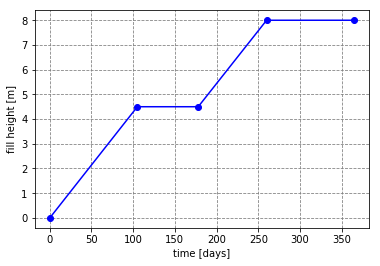

In [61]:
plt.plot(T, H, 'b-o')
plt.xlabel('time [days]')
plt.ylabel('fill height [m]')
plt.grid(linestyle='--',color='grey')

Plot the settlement versus time

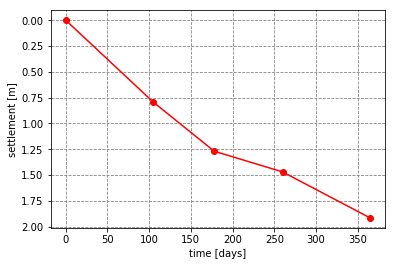

In [62]:
plt.plot(T, S, 'r-o')
plt.xlabel('time [days]')
plt.ylabel('settlement [m]')
plt.grid(linestyle='--',color='grey')
plt.gca().invert_yaxis()

Plot the excess pore water pressure due to the first embankment

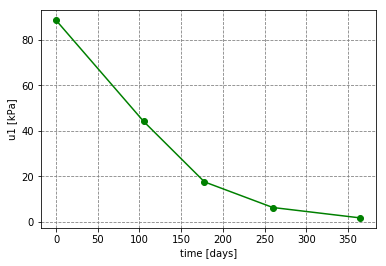

In [63]:
plt.plot(T, U1, 'g-o')
plt.xlabel('time [days]')
plt.ylabel('u1 [kPa]')
plt.grid(linestyle='--',color='grey')

Plot the excess pore water pressure due to the second embankment

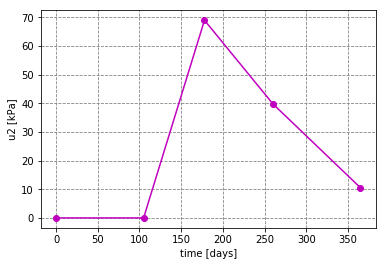

In [64]:
plt.plot(T, U2, 'm-o')
plt.xlabel('time [days]')
plt.ylabel('u2 [kPa]')
plt.grid(linestyle='--',color='grey')